# EDA and Cleaning

In [223]:
import requests
import time
import pandas as pd
import json
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor, Json
import matplotlib.pyplot as plt
import numpy as np
import re
from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

In [2]:
%run ../bx_sql.py

## Configure PostgreSQL Server with Docker

In [3]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

def insert_entry_json(data, tablename=None):
    con, cur = con_cur_to_db()
    for x in data:
        cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
    con.commit()
    con.close()

## Retrieve Data from PostgreSQL Database

### Books

In [4]:
books_query = '''SELECT * FROM books;
'''

books_results = execute_query(books_query, dict_cur=True)

In [5]:
books_df = pd.DataFrame(books_results)

### Users

In [6]:
users_query = '''SELECT * FROM users;
'''

users_results = execute_query(users_query, dict_cur=True)

In [7]:
users_df = pd.DataFrame(users_results)

### Book Ratings

In [8]:
ratings_query = '''SELECT * FROM book_ratings;
'''

ratings_results = execute_query(ratings_query, dict_cur=True)

In [9]:
ratings_df = pd.DataFrame(ratings_results)

## Clean Data

### Books

In [10]:
books_df.head()

,book_author,book_title,image_url_l,image_url_m,image_url_s,isbn,publisher,year_of_publication
0,Mark P. O. Morford,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0195153448,Oxford University Press,2002
1,Richard Bruce Wright,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,0002005018,HarperFlamingo Canada,2001
2,Carlo D'Este,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,0060973129,HarperPerennial,1991
3,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,0374157065,Farrar Straus Giroux,1999
4,E. J. W. Barber,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,0393045218,W. W. Norton &amp; Company,1999


In [11]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
book_author            271378 non-null object
book_title             271379 non-null object
image_url_l            271379 non-null object
image_url_m            271379 non-null object
image_url_s            271379 non-null object
isbn                   271379 non-null object
publisher              271377 non-null object
year_of_publication    271379 non-null int64
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


In [12]:
books_df.drop(columns=['image_url_l', 'image_url_m', 'image_url_s'], inplace=True)

In [13]:
books_df.isna().sum()

book_author            1
book_title             0
isbn                   0
publisher              2
year_of_publication    0
dtype: int64

##### Author

In [14]:
books_df[books_df['book_author'].isna()]

,book_author,book_title,isbn,publisher,year_of_publication
187714,None,The Credit Suisse Guide to Managing Your Perso...,9627982032,Edinburgh Financial Publishing,1995


[Amazon (The Credit Suisse Guide to Managing Your Personal Wealth)](https://www.amazon.ca/Credit-Suisse-Managing-Personal-Wealth/dp/9627982075)

##### Publisher

In [15]:
books_df.loc[187714, ['book_author']] = 'Larissa Anne Downes'

In [16]:
books_df[books_df['publisher'].isna()]

,book_author,book_title,isbn,publisher,year_of_publication
128920,Elaine Corvidae,Tyrant Moon,193169656X,None,2002
129068,Linnea Sinclair,Finders Keepers,1931696993,None,2001


Sources:
-  [AbeBooks (Tyrant Moon)](https://www.abebooks.com/9781931696562/Tyrant-Moon-Elaine-Corvidae-193169656X/plp)
-  [Google Books (Finders Keepers)](https://books.google.com/books/about/Finders_Keepers.html?id=M9pbPgAACAAJ)

In [17]:
books_df.loc[128920, ['publisher']] = 'Novelbooks Incorporated'

In [18]:
books_df.loc[129068, ['publisher']] = 'Novelbooks Incorporated'

##### Year of Publication ????

In [19]:
np.asarray(sorted(books_df['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

In [20]:
books_df[books_df['year_of_publication'] == 0].head()

,book_author,book_title,isbn,publisher,year_of_publication
177,Schiller,Kabale Und Liebe,3150000335,"Philipp Reclam, Jun Verlag GmbH",0
189,Gabriel Garcia Marquez,Die Liebe in Den Zelten,342311360X,Deutscher Taschenbuch Verlag (DTV),0
289,Barbara Kingsolver,Poisonwood Bible Edition Uk,0571197639,Faber Faber Inc,0
352,Golding,"Herr Der Fliegen (Fiction, Poetry and Drama)",3596214629,Fischer Taschenbuch Verlag GmbH,0
542,P Coelho,Biblioteca Universale Rizzoli: Sulla Sponda De...,8845229041,Fabbri - RCS Libri,0


In [21]:
books_df[books_df['year_of_publication'] >= 2005].head()

,book_author,book_title,isbn,publisher,year_of_publication
3547,Grant Naylor,Red Dwarf,0140124373,Penguin Books Ltd,2005
12799,Kathleen E. Woodiwiss,A Rose in Winter,0380816792,Harper Mass Market Paperbacks,2011
26187,Frances Sakoian,The Astrologer's Handbook,006272004X,HarperResource,2005
30030,Kitty Kelley,The Royals,068160204X,Bausch &amp; Lombard,2020
37505,Coville,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,0671746103,Aladdin,2030


In [22]:
url = 'https://www.goodreads.com/book/isbn/ISBN?format=xml&isbn=3150000335&key=prkLqGzgF7KgNNy3VqgJpQ'
response = requests.get(url)

In [23]:
soup = BeautifulSoup(response.text, 'xml')

In [24]:
int(soup.find('original_publication_year').text)

1901

##### ISBN

In [25]:
books_df['isbn'].nunique()

271379

##### Title

In [26]:
books_df['book_title'].nunique()

242154

In [27]:
len(books_df[books_df['book_title'].duplicated()])

29225

In [28]:
books_df[['book_title']].loc[2280: 2283]

,book_title
2280,Die Spinne und das MÃ?Â¤dchen.
2281,Die Bildhauerin.
2282,20 Jahre 40 bleiben. Jung und schÃ?Â¶n in den ...
2283,Goddess Blood: Book One of the Goddess Trilogy


In [29]:
books_df[books_df['book_title'] == 'Angels &amp; Demons']

,book_author,book_title,isbn,publisher,year_of_publication
119,Dan Brown,Angels &amp; Demons,0671027360,Pocket Star,2001
240,Dan Brown,Angels &amp; Demons,0743486226,Atria,2003
28021,Dan Brown,Angels &amp; Demons,0671027352,Atria,2000
36952,Dan Brown,Angels &amp; Demons,0743535774,Audioworks,2003
163571,Dan Brown,Angels &amp; Demons,0743535766,Simon &amp; Schuster Audio,2003


In [30]:
books_unique_df = books_df.drop_duplicates(subset=['book_author','book_title'])

In [31]:
good_isbns = books_df['isbn'].map(lambda x: x if re.findall('^[\dXx]+$', x) else None)

In [32]:
bad_isbns = dict(zip(books_df[good_isbns.isna()].isbn, zip(books_df[good_isbns.isna()].book_author, books_df[good_isbns.isna()].book_title)))

In [33]:
unique_good_isbns = books_df[good_isbns.notnull()].drop_duplicates(['book_author', 'book_title'])

In [34]:
replacement_isbn = {}

In [35]:
for bad_isbn, (author, title) in bad_isbns.items():
    replacement_isbn[bad_isbn] = str(unique_good_isbns[(unique_good_isbns['book_author'] == author) & (unique_good_isbns['book_title'] == title)]['isbn'].values)

In [36]:
books_df.isbn.map(lambda x: replacement_isbn.get(x) if replacement_isbn.get(x) else x)

0         0195153448
1         0002005018
2         0060973129
3         0374157065
4         0393045218
5         0399135782
6         0425176428
7         0671870432
8         0679425608
9         074322678X
10        0771074670
11        080652121X
12        0887841740
13        1552041778
14        1558746218
15        1567407781
16        1575663937
17        1881320189
18        0440234743
19        0452264464
20        0609804618
21        1841721522
22        1879384493
23        0061076031
24        0439095026
25        0689821166
26        0971880107
27        0345402871
28        0345417623
29        0684823802
             ...    
271349    3320016822
271350    3423200944
271351    3453065123
271352    3525335423
271353    3548740146
271354    381440176X
271355    3893312307
271356    0971854823
271357    0316640786
271358    3257217323
271359    3596156904
271360    1874166633
271361    0130897930
271362    020130998X
271363    2268032019
271364    0684860112
271365    039

In [37]:
np.asarray(sorted(books_unique_df['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925,
       1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936,
       1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947,
       1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2008, 2011, 2012, 2020, 2024, 2026, 2030,
       2037, 2038, 2050])

In [38]:
incorrect_year = books_unique_df[(books_unique_df['year_of_publication'] == 0) | (books_unique_df['year_of_publication'] > 2004)] 

In [39]:
incorrect_year.to_csv('../data/books_incorrect_year.csv')

### Users

In [40]:
users_df.head()

,age,location,user_id
0,None,"nyc, new york, usa",1
1,18.0,"stockton, california, usa",2
2,None,"moscow, yukon territory, russia",3
3,17.0,"porto, v.n.gaia, portugal",4
4,None,"farnborough, hants, united kingdom",5


In [41]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
age         168096 non-null object
location    278858 non-null object
user_id     278858 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


#### User ID

In [42]:
users_df['user_id'].nunique() == len(users_df)

True

#### Age

In [43]:
np.asarray(users_df['age'].unique())

array([None, Decimal('18.0'), Decimal('17.0'), Decimal('61.0'),
       Decimal('26.0'), Decimal('14.0'), Decimal('25.0'), Decimal('19.0'),
       Decimal('46.0'), Decimal('55.0'), Decimal('32.0'), Decimal('24.0'),
       Decimal('20.0'), Decimal('34.0'), Decimal('23.0'), Decimal('51.0'),
       Decimal('31.0'), Decimal('21.0'), Decimal('44.0'), Decimal('30.0'),
       Decimal('57.0'), Decimal('43.0'), Decimal('37.0'), Decimal('41.0'),
       Decimal('54.0'), Decimal('42.0'), Decimal('50.0'), Decimal('39.0'),
       Decimal('53.0'), Decimal('47.0'), Decimal('36.0'), Decimal('28.0'),
       Decimal('35.0'), Decimal('13.0'), Decimal('58.0'), Decimal('49.0'),
       Decimal('38.0'), Decimal('45.0'), Decimal('62.0'), Decimal('63.0'),
       Decimal('27.0'), Decimal('33.0'), Decimal('29.0'), Decimal('66.0'),
       Decimal('40.0'), Decimal('15.0'), Decimal('60.0'), Decimal('0.0'),
       Decimal('79.0'), Decimal('22.0'), Decimal('16.0'), Decimal('65.0'),
       Decimal('59.0'), Decimal('48.0

In [44]:
len(users_df[users_df['age'] >= 90])

435

In [45]:
len(users_df[users_df['age'] <= 5])

908

In [46]:
(users_df['age'].isna().sum() + len(users_df[users_df['age'] >= 90]) + len(users_df[users_df['age'] <= 5]))/ len(users_df)

0.40201464544678656

In [47]:
users_df.drop(columns='age', inplace=True)

#### Location

In [48]:
for i in users_df['location']:
    if ',' not in i:
        print(i)

lawrenceville


In [49]:
users_df[users_df['location'] == 'lawrenceville']

,location,user_id
134376,lawrenceville,134377


In [50]:
users_df.loc[134376, 'location'] = 'lawrenceville, , '

In [51]:
users_df['city'] = users_df['location'].apply(lambda x: x.split(',')[0])

In [52]:
users_df['state'] = users_df['location'].apply(lambda x: re.findall(r'.*[,,]\s(.*)[,]', x))
users_df['state'] = users_df['state'].map(lambda x: None if not x else x[0])

In [53]:
users_df['country'] = users_df['location'].apply(lambda x: re.findall(r'.*[,,].*[,]\s(.*)', x))
users_df['country'] = users_df['country'].map(lambda x: None if not x else x[0])

In [54]:
users_df.head()

,location,user_id,city,state,country
0,"nyc, new york, usa",1,nyc,new york,usa
1,"stockton, california, usa",2,stockton,california,usa
2,"moscow, yukon territory, russia",3,moscow,yukon territory,russia
3,"porto, v.n.gaia, portugal",4,porto,v.n.gaia,portugal
4,"farnborough, hants, united kingdom",5,farnborough,hants,united kingdom


In [55]:
users_df.isna().sum()

location       0
user_id        0
city           0
state          1
country     4573
dtype: int64

In [56]:
users_df[users_df['state'].isna()]

,location,user_id,city,state,country
29419,"st. louis, missouri",29420,st. louis,None,None


In [57]:
users_df[users_df['country'].isna()].head()

,location,user_id,city,state,country
18,"weston, ,",19,weston,,None
90,"toronto/newmarket, ,",91,toronto/newmarket,,None
311,"lk, jlk,",312,lk,jlk,None
317,"berlin, n/a,",318,berlin,n/a,None
536,"davis, california,",537,davis,california,None


### Book Ratings

In [58]:
ratings_df.head()

,book_rating,isbn,user_id
0,0,034545104X,276725
1,5,0155061224,276726
2,0,0446520802,276727
3,3,052165615X,276729
4,6,0521795028,276729


In [59]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
book_rating    1149780 non-null int64
isbn           1149780 non-null object
user_id        1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


#### ISBN

In [60]:
print('Ratings ISBN:',ratings_df['isbn'].nunique())
print('Books ISBN:  ',books_df['isbn'].nunique())
ratings_df['isbn'].nunique() == books_df['isbn'].nunique()

Ratings ISBN: 340556
Books ISBN:   271379


False

In [61]:
ratings_match_df = ratings_df[ratings_df['isbn'].isin(books_df['isbn'])]

In [62]:
print('Number of Ratings:',ratings_match_df.shape[0])
print('Number of Books:  ',ratings_match_df['isbn'].nunique())

Number of Ratings: 1031175
Number of Books:   270170


In [63]:
books_three_plus = ratings_match_df['isbn'].value_counts().keys()[ratings_match_df['isbn'].value_counts() >= 3]

In [64]:
ratings_match_df = ratings_match_df[ratings_match_df['isbn'].isin(books_three_plus.values)]

In [65]:
print('Number of Ratings:',ratings_match_df.shape[0])
print('Number of Books:  ',ratings_match_df['isbn'].nunique())

Number of Ratings: 788645
Number of Books:   76076


In [66]:
ratings_match_df['isbn'].value_counts().values

array([2502, 1295,  883, ...,    3,    3,    3])

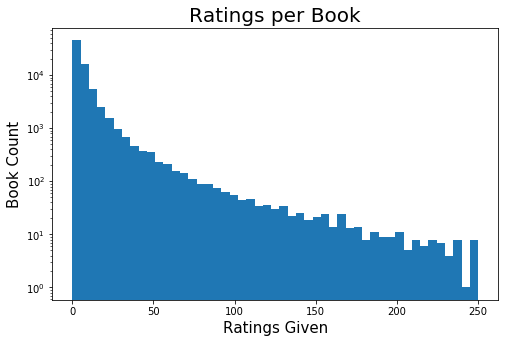

In [110]:
plt.figure(figsize=(8, 5))
plt.hist(x=ratings_match_df['isbn'].value_counts().values,
         bins=np.linspace(0,250,50))
plt.gca().set_yscale("log")
plt.title('Ratings per Book', fontsize=20)
plt.xlabel('Ratings Given', fontsize=15)
plt.ylabel('Book Count', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

In [68]:
# ratings_match_df['isbn'].apply(lambda x: re.findall('\d+X?', x))

#### User ID

In [69]:
ratings_match_df['user_id'].value_counts().values

array([9276, 4322, 4082, ...,    1,    1,    1])

In [70]:
ratings_match_df['user_id'].nunique()

80930

In [71]:
users_three_plus = ratings_match_df['user_id'].value_counts().keys()[ratings_match_df['user_id'].value_counts() >= 3]

In [72]:
ratings_match_df = ratings_match_df[ratings_match_df['user_id'].isin(users_three_plus.values)]

#### why are there 1s???

In [73]:
ratings_match_df['isbn'].value_counts().values

array([1707, 1045,  766, ...,    1,    1,    1])

In [74]:
print('Number of Ratings:',ratings_match_df.shape[0])
print('Number of Users:  ',ratings_match_df['user_id'].nunique())

Number of Ratings: 723863
Number of Users:   25897


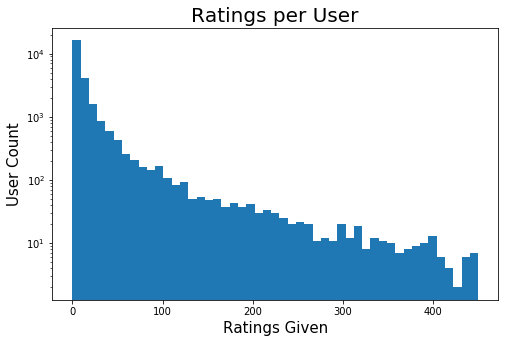

In [117]:
plt.figure(figsize=(8, 5))
plt.hist(x=ratings_match_df['user_id'].value_counts().values,
         bins=np.linspace(0,450,50))
plt.gca().set_yscale("log")
plt.title('Ratings per User', fontsize=20)
plt.xlabel('Ratings Given', fontsize=15)
plt.ylabel('User Count', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

#### Book Rating

In [76]:
ratings_match_df['book_rating'].value_counts().sort_index()

0     472328
1        864
2       1472
3       3260
4       4814
5      27663
6      20585
7      43623
8      60999
9      41923
10     46332
Name: book_rating, dtype: int64

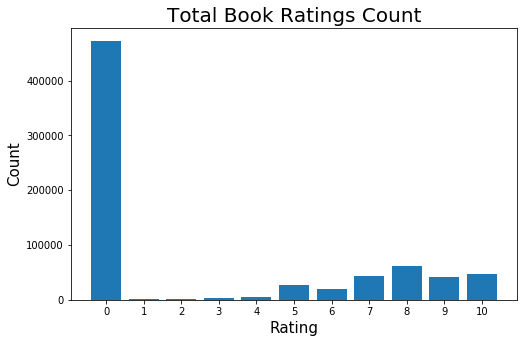

In [77]:
plt.figure(figsize=(8, 5))
plt.bar(x=ratings_match_df['book_rating'].value_counts().index,
        height=ratings_match_df['book_rating'].value_counts().values)
plt.title('Total Book Ratings Count', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=10)
plt.yticks(fontsize=10);

In [78]:
ratings_explicit_df = ratings_match_df[ratings_match_df['book_rating'] != 0]
ratings_implicit_df = ratings_match_df[ratings_match_df['book_rating'] == 0]

In [79]:
ratings_match_df[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,723863.0,2.664384,3.804532,0.0,0.0,0.0,7.0,10.0


In [80]:
ratings_explicit_df[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,251535.0,7.667517,1.814581,1.0,7.0,8.0,9.0,10.0


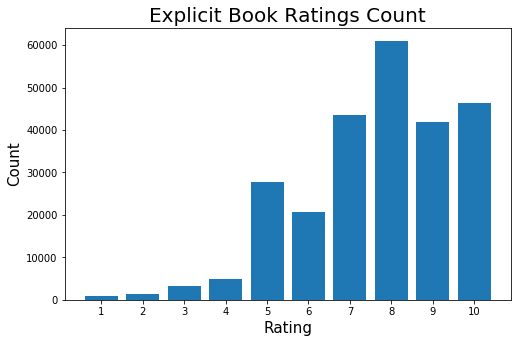

In [81]:
plt.figure(figsize=(8, 5))
plt.bar(x=ratings_explicit_df['book_rating'].value_counts().index,
        height=ratings_explicit_df['book_rating'].value_counts().values)
plt.title('Explicit Book Ratings Count', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ratings_explicit_df['book_rating'].value_counts().index, fontsize=10)
plt.yticks(fontsize=10);

## Combine `books` and `ratings`

In [82]:
ratings_match_df.head()

,book_rating,isbn,user_id
10,0,0425115801,276746
11,0,0449006522,276746
12,0,0553561618,276746
13,0,055356451X,276746
14,0,0786013990,276746


In [83]:
ratings_match_df.shape[0]

723863

In [84]:
books_df.head()

,book_author,book_title,isbn,publisher,year_of_publication
0,Mark P. O. Morford,Classical Mythology,0195153448,Oxford University Press,2002
1,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001
2,Carlo D'Este,Decision in Normandy,0060973129,HarperPerennial,1991
3,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...,0374157065,Farrar Straus Giroux,1999
4,E. J. W. Barber,The Mummies of Urumchi,0393045218,W. W. Norton &amp; Company,1999


In [85]:
books_df.shape[0]

271379

In [86]:
books_unique_df.head()

,book_author,book_title,isbn,publisher,year_of_publication
0,Mark P. O. Morford,Classical Mythology,0195153448,Oxford University Press,2002
1,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001
2,Carlo D'Este,Decision in Normandy,0060973129,HarperPerennial,1991
3,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...,0374157065,Farrar Straus Giroux,1999
4,E. J. W. Barber,The Mummies of Urumchi,0393045218,W. W. Norton &amp; Company,1999


In [87]:
books_unique_df.shape[0]

251204

In [88]:
ratings_and_books = ratings_match_df.merge(books_df[['isbn', 'book_author', 'book_title']], how='left')

In [89]:
ratings_and_books.head()

,book_rating,isbn,user_id,book_author,book_title
0,0,0425115801,276746,Dean R. Koontz,Lightning
1,0,0449006522,276746,JOHN SAUL,Manhattan Hunt Club
2,0,0553561618,276746,TAMI HOAG,Dark Paradise
3,0,055356451X,276746,TAMI HOAG,Night Sins
4,0,0786013990,276746,David Dun,At the Edge


In [90]:
ratings_and_books.shape[0]

723863

In [91]:
new_ratings_and_books = books_unique_df.merge(ratings_and_books.drop(columns='isbn'), on=['book_author', 'book_title'])

In [92]:
new_ratings_and_books.head()

,book_author,book_title,isbn,publisher,year_of_publication,book_rating,user_id
0,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,5,8
1,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,0,11400
2,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,8,11676
3,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,0,41385
4,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,8,67544


In [93]:
new_ratings_and_books.shape[0] == ratings_and_books.shape[0]

True

In [94]:
new_ratings_and_books['user_id'].nunique()

25897

## Ratings Count

In [95]:
total_count = new_ratings_and_books.groupby('isbn', as_index=False)[['book_rating']].count().rename(columns={'book_rating': 'total_count'})
explicit_count = new_ratings_and_books[new_ratings_and_books['book_rating'] != 0].groupby('isbn', as_index=False)[['book_rating']].count().rename(columns={'book_rating': 'explicit_count'})

In [96]:
ratings_count = total_count.merge(explicit_count, how='outer', on='isbn').fillna(0).astype({'explicit_count': int})

In [97]:
ratings_count.head()

,isbn,total_count,explicit_count
0,0001046438,8,2
1,0001837397,3,1
2,0001841572,3,0
3,0001848445,2,0
4,0001900277,2,0


In [98]:
ratings_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69591 entries, 0 to 69590
Data columns (total 3 columns):
isbn              69591 non-null object
total_count       69591 non-null int64
explicit_count    69591 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


In [99]:
ratings_count[ratings_count['explicit_count'] == 0].shape[0]

14022

In [100]:
total_count.tail()

,isbn,total_count
69586,B00007MF56,12
69587,B00009APKU,11
69588,B0000A2U93,8
69589,B00013AX6W,6
69590,B0001GDNCK,25


In [173]:
books_df[books_df['book_title'] == 'After the Plague: And Other Stories']

,book_author,book_title,isbn,publisher,year_of_publication
108622,T. Coraghessan Boyle,After the Plague: And Other Stories,B00013AX6W,Viking Press,2001
148180,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Books,2001


In [179]:
new_ratings_and_books[new_ratings_and_books['isbn'] == '0670030058'].head()

,book_author,book_title,isbn,publisher,year_of_publication,book_rating,user_id
656608,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Press,2001,0,11676
656609,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Press,2001,0,35859
656610,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Press,2001,0,81088
656611,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Press,2001,0,114414
656612,T. Coraghessan Boyle,After the Plague: And Other Stories,0670030058,Viking Press,2001,0,187145


In [177]:
total_count.tail(7)

,isbn,total_count
69584,081440491X,3
69585,B0000633PU,2
69586,0743223306,12
69587,1561560936,11
69588,1843500728,8
69589,0670030058,6
69590,0671644467,25


In [128]:
total_count.loc[69590, ['isbn']] = '0671644467'

total_count.loc[69584, ['isbn']] = '081440491X'

total_count.loc[69586, ['isbn']] = '0743223306'

total_count.loc[69587, ['isbn']] = '1561560936'

total_count.loc[69588, ['isbn']] = '1843500728'

total_count.loc[69589, ['isbn']] = '0670030058'

In [131]:
new_ratings_and_books.replace(to_replace='B0001GDNCK', value='0671644467', inplace=True)

new_ratings_and_books.replace(to_replace='B00005U7YK', value='081440491X', inplace=True)

new_ratings_and_books.replace(to_replace='B00007MF56', value='0743223306', inplace=True)

new_ratings_and_books.replace(to_replace='B00009APKU', value='1561560936', inplace=True)

new_ratings_and_books.replace(to_replace='B0000A2U93', value='1843500728', inplace=True)

new_ratings_and_books.replace(to_replace='B00013AX6W', value='0670030058', inplace=True)

## Save Explicit Ratings ONLY

In [182]:
remove_imp = new_ratings_and_books[new_ratings_and_books['book_rating'] != 0]

In [189]:
isbn_greater_three = remove_imp['isbn'].value_counts().index[remove_imp['isbn'].value_counts().values > 3]

In [193]:
exp_ratings = remove_imp[remove_imp['isbn'].isin(isbn_greater_three)]

In [195]:
exp_ratings.head()

,book_author,book_title,isbn,publisher,year_of_publication,book_rating,user_id
0,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,5,8
2,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,8,11676
4,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,8,67544
7,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,9,116866
9,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001,8,200273


In [210]:
exp_ratings.shape[0]

183150

In [211]:
exp_ratings['isbn'].nunique()

15479

In [201]:
exp_ratings = exp_ratings[['isbn', 'user_id', 'book_rating']]

In [202]:
ratings_list = exp_ratings.to_dict('list')

In [204]:
wide_ratings = {}
for user, book, rating in zip(ratings_list['user_id'], ratings_list['isbn'], ratings_list['book_rating']):
    if wide_ratings.get(user):
        wide_ratings[user][book] = rating
    else:
        wide_ratings[user] = {book: rating}

In [208]:
wide_ratings_sdf = pd.SparseDataFrame(wide_ratings)

In [209]:
wide_ratings_sdf.head()

,8,11676,67544,116866,200273,210926,219008,263325,35704,110912,...,255028,254022,119146,191709,223503,227835,278089,241294,145374,152469
0002005018,5.0,8.0,8.0,9.0,8.0,9.0,7.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002251760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002259834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002550563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0003300277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
ratings_scaled = (wide_ratings_sdf - np.nanmean(wide_ratings_sdf, axis=0))/np.nanstd(wide_ratings_sdf, axis=0) 

In [222]:
ratings_scaled.head()

,8,11676,67544,116866,200273,210926,219008,263325,35704,110912,...,255028,254022,119146,191709,223503,227835,278089,241294,145374,152469
0002005018,NaN,0.259098,0.866025,1.005141,1.0,0.559017,0.25,-1.512048,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002251760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002259834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002550563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0003300277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [230]:
svd = TruncatedSVD(n_components=100, random_state=44)

In [231]:
svd_ratings = svd.fit_transform(ratings_scaled.fillna(0).T)

In [232]:
svd_ratings.shape

(22774, 100)

In [271]:
svd.components_.shape

(100, 15479)

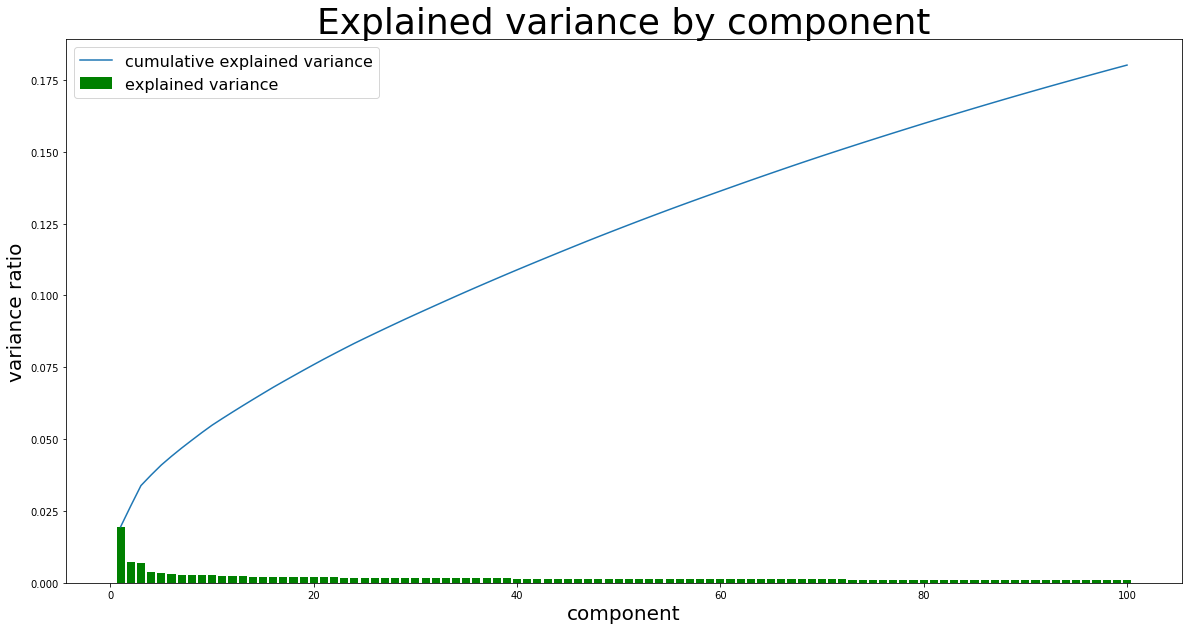

In [278]:
fig = plt.figure(figsize=(20,10))
plt.bar(np.array(range(100))+1, 
        svd.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(100))+1, 
         np.cumsum(svd.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend(fontsize=16)
plt.xlabel('component', fontsize=20)
plt.ylabel('variance ratio', fontsize=20)
plt.title('Explained variance by component', fontsize=36);

In [257]:
len(ratings_scaled.index.get_values())

15479

In [234]:
U = pairwise_distances(svd_ratings, svd_ratings, metric="cosine")

In [261]:
ratings_scaled.index.tolist().index('0002005018')

0

In [284]:
target_book = ratings_scaled.index.tolist().index('0688088686')

In [285]:
book_sim = U[target_book]

In [286]:
recs = pd.DataFrame(
    list(zip(ratings_scaled.index.tolist(), book_sim)), columns=['book', 'distance'])

In [287]:
recs.sort_values('distance').head(10)

,book,distance
11592,0688088686,0.000000
11591,0688084923,0.042041
11580,0688046134,0.080345
11588,0688078028,0.081485
11585,0688065317,0.145916
198,0060177209,0.412170
2355,0312985207,0.448609
3273,0345450663,0.492607
8474,0515134899,0.504668
2786,0345339738,0.509952


In [294]:
remove_imp[(remove_imp['isbn'] == '0688088686') | (remove_imp['isbn'] == '0688084923')]

,book_author,book_title,isbn,publisher,year_of_publication,book_rating,user_id
248216,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,10,31315
248218,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,8,50110
248219,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,10,59172
248220,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,8,74687
248221,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,7,78471
248222,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,9,81672
248226,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,7,135618
248228,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,9,152955
248233,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,8,178522
248234,Sidney Sheldon,"Morning, Noon, and Night",0688084923,William Morrow &amp; Company,1995,7,184513


In [291]:
ratings_scaled.loc['0374157065', 209163]

nan

In [293]:
# imp_dict

In [270]:
# imp_dict

## Save as CSV

In [103]:
new_ratings_and_books.to_csv('../data/ratings_and_books.csv')

In [104]:
new_ratings_and_books[new_ratings_and_books['book_rating'] != 0].to_csv('../data/explicit_ratings.csv')

In [105]:
implicit = new_ratings_and_books[new_ratings_and_books.book_rating == 0][['isbn', 'user_id']].to_dict('list')

In [106]:
imp_dict = dict(zip(implicit['isbn'], implicit['user_id']))

In [107]:
len(imp_dict)

67334